In [1]:
import numpy as np
from scipy.integrate import odeint
import scipy.stats
import matplotlib.pyplot as plt
import copy

In [2]:

# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

# Nominal trajectory, measurements

In [230]:
class MonoCamera:
    def __init__(self):
        self.std = 0.1
        self.v = scipy.stats.norm(0, self.std)

    def control(self, X, t):
        #g_des = (np.sin(0.05*t)+1)**4*np.sin(0.5*t)
        #g_des = np.sin(2*t)
        #g, d = X
        #gain = 0.5
        u_g = 4*np.sin(2*t) #gain*(g_des-g)
        return u_g

    def f(self, X, t):
        g, d = X
        # control
        u_g = self.control(X, t)
        # dynamics
        g_dot = u_g # - 0.01*g
        d_dot = 0.5
        x_dot = [g_dot, d_dot]
        return x_dot

    def h(self, X, t):
        g, d = X
        u_g = self.control(X, t)
        y = np.array([g/d ])
        return y

    def simulate(self, x0, tsim):
        result = odeint(self.f, x0, tsim)
        X = result.T
        U = np.atleast_2d(self.control(X, tsim))
        Y = self.h(X, tsim)
        return X, U, Y

In [231]:
sys = MonoCamera()

x0 = np.array([5, 3])
tsim = np.arange(0, 20, 0.01)

X, U, Y = sys.simulate(x0, tsim)

In [232]:
print(X.shape)
print(Y.shape)
print(U.shape)

(2, 2000)
(1, 2000)
(1, 2000)


Text(0, 0.5, 'Measurement values')

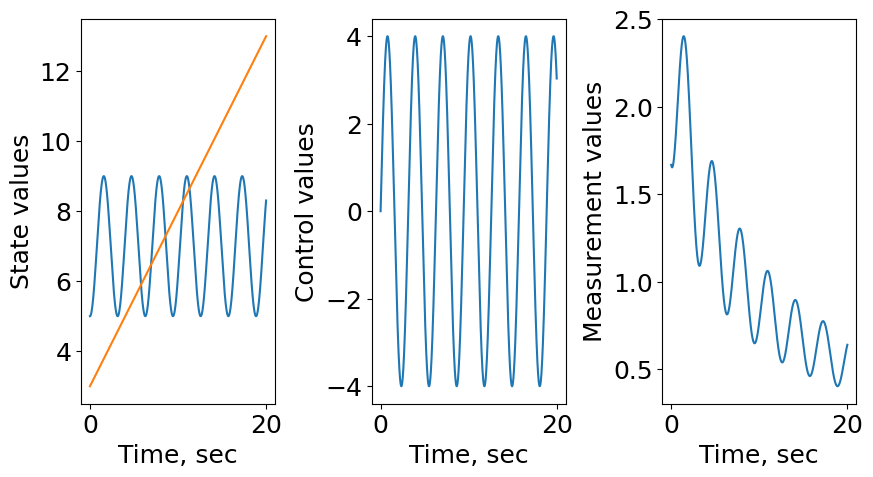

In [233]:
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(wspace=0.5)

# States
ax = fig.add_subplot(131)

ax.plot(tsim, X[0,:])
ax.plot(tsim, X[1,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('State values')

# Controls
ax = fig.add_subplot(132)

ax.plot(tsim, U[0,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('Control values')

# Measurements
ax = fig.add_subplot(133)

ax.plot(tsim, Y[0,:])
#ax.plot(tsim, Y[1,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('Measurement values')

Sparse model of the measurements

In [234]:
Xt = X.T
Yt = Y.T

In [235]:
Xtnorm = copy.copy(Xt)
std = np.std(Xt,axis=0)
for i in range(len(std)):
  Xtnorm[:,i] = Xt[:,i]/std[i]

In [236]:
print(Xt.shape)
print(Yt.shape)

(2000, 2)
(2000, 1)


In [237]:
def build_library(X):
  x1 = X[0,:]
  x2 = X[1,:]
  library = [np.ones_like(x1), x1, x2, x1**-1, x2**-1, x1/x2, x2/x1]
  return np.vstack(library).T

In [238]:
lib = build_library(X)

In [239]:
lib.shape

(2000, 7)

In [240]:
def cost_function(p):
  P = np.atleast_2d(p).T
  L1 = np.linalg.norm(Yt - lib@P, 1)
  L2 = np.sum(np.abs(P))
  L = L1 + 100*L2
  return L

In [241]:
from scipy.optimize import minimize

In [242]:
lib.shape[1]

7

In [243]:
p0 = np.random.normal(0,1,lib.shape[1])
result = minimize(cost_function, p0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 423.044314
         Iterations: 856
         Function evaluations: 1357


In [244]:
result.x

array([ 9.98848320e-01, -7.58362788e-02,  5.94848170e-02, -5.05336948e-01,
        4.81306388e-12,  8.10650921e-01, -5.94061833e-01])

In [245]:
P = np.atleast_2d(result.x).T

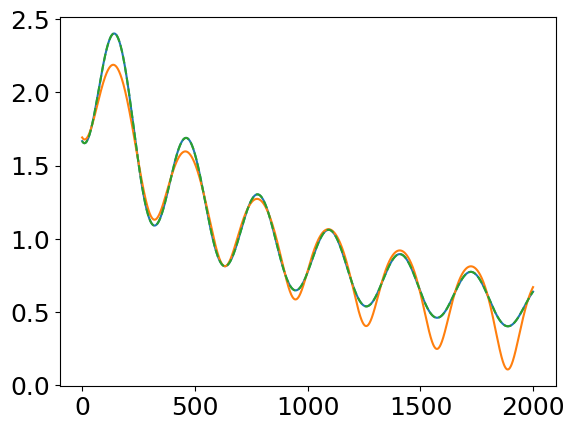

In [246]:
plt.plot(Yt)
pred_measurements = lib@P
plt.plot(pred_measurements)
plt.plot(lib[:,-2], '--')

In [222]:
lib.shape

(2000, 7)